# **Interpretable Data Science - Individual Project**

##### Data information: https://www.kaggle.com/datasets/nimapourmoradi/raisin-binary-classification

# 1. Set-up the enviroment

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import pandas as pd 
import numpy as np 
import warnings


# For logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# For CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# For classic model
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# For Multilayer Perceptron (MLP)
from sklearn.neural_network import MLPClassifier

# For Other
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import loguniform
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score

2024-05-13 08:18:44.173631: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 08:18:44.904985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 2. Reading data and clean data

In [3]:
# Read data
data= pd.read_csv('Raisin_Dataset.csv')

In [4]:
data.dtypes

Area                 int64
MajorAxisLength    float64
MinorAxisLength    float64
Eccentricity       float64
ConvexArea           int64
Extent             float64
Perimeter          float64
Class               object
dtype: object

In [5]:
# Checking data
print(data.isnull().sum()) # Missing value
print(data.duplicated().sum()) # Duplicate value

Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
Extent             0
Perimeter          0
Class              0
dtype: int64
0


In [6]:
# Original shape of the data
original_shape = data.shape

# Outlier
from scipy import stats
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()
z_scores = stats.zscore(data[numeric_columns])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data_cleaned = data[filtered_entries]

In [7]:
# Count outliers
outliers_removed = original_shape[0] - data_cleaned.shape[0]
print("Number of outliers removed:", outliers_removed)

Number of outliers removed: 40


In [8]:
# Encode label
class_mapping = {
    'Kecimen': 0,
    'Besni': 1
}

# Assuming your DataFrame is named 'data_cleaned'
data_cleaned['Class'] = data_cleaned['Class'].map(class_mapping)

/tmp/ipykernel_34306/2118130042.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Class'] = data_cleaned['Class'].map(class_mapping)


# 3. Modeling

## 3.1 Split data

In [9]:
# Define the features and the target
X = data_cleaned.drop('Class', axis=1)
y = data_cleaned['Class']

# Split the data into training and remaining data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  
# Split the remaining 30% data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the sizes of each set to confirm
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 602
Validation set size: 129
Test set size: 129


## 3.2 Default Interpretable Model 

In [10]:
# Define the models to evaluate
models = {
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()}

# Prepare to store the results
results = []

In [11]:
# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)  # Train model on training data
    y_val_pred = model.predict(X_val)  # Predict on validation data
    y_val_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else y_val_pred

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_val_pred)
    auc = roc_auc_score(y_val, y_val_prob) if hasattr(model, "predict_proba") else float('nan')
    f1 = f1_score(y_val, y_val_pred)

    # Append results to the list
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'AUC': auc,
        'F1': f1
    })

# Convert to dataframe
results_df = pd.DataFrame(results)

In [12]:
results_df

,Model,Accuracy,AUC,F1
0,Logistic Regression,0.844961,0.884785,0.821429
1,Decision Tree,0.767442,0.771649,0.750000
2,K-Nearest Neighbors,0.806202,0.848337,0.770642


**Final Choice: Logistic Regression**

1. **High Accuracy**: Logistic Regression outperformed other models with an accuracy of 0.845.

2. **Interpretability**: Its straightforward coefficient interpretation enhances model transparency.

**Conclusion:** Logistic Regression offers a balance of accuracy and interpretability, making it the optimal choice for this assignment.

## 3.3 Interpretable Model - Hyperparameter Tuning

In [13]:
# Filter out any warnings
warnings.filterwarnings("ignore")

param_dist = {
    'C': loguniform(1e-5, 100),  # Regularization strength
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga']  # Solver algorithms
}

# Initialize Logistic Regression classifier
logistic_regression = LogisticRegression(max_iter=1000)

# Perform randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(logistic_regression, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)

# Fit randomized search to training data
random_search.fit(X_train, y_train)

# Get best parameters and best model
best_params = random_search.best_params_
best_lg = random_search.best_estimator_

# Evaluate the best model on validation data
accuracy = best_lg.score(X_val, y_val)
print("Best Parameters:", best_params)
print("Validation Accuracy:", accuracy)
print("Validation AUC:", auc)
print("Validation F1 Score:", f1)

# Re-enable warnings
warnings.filterwarnings("default")

Best Parameters: {'C': 0.00013444634828135534, 'solver': 'lbfgs'}
Validation Accuracy: 0.8449612403100775
Validation AUC: 0.8483365949119374
Validation F1 Score: 0.7706422018348624


## 3.5 Default"Black-box" Model

In [14]:
# Define a common random seed
random_seed = 40

# Define the models to evaluate
models = {
    'Neural Network': make_pipeline(StandardScaler(), MLPClassifier(max_iter=1000, random_state=random_seed)),
    'Gradient Boosting': GradientBoostingClassifier(random_state=random_seed),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=random_seed),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', seed=random_seed)
}

# Prepare to store the results
results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)  
    y_val_pred = model.predict(X_val) 
    y_val_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else [float('nan')] * len(y_val)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_val_pred)
    auc = roc_auc_score(y_val, y_val_prob) if hasattr(model, 'predict_proba') else float('nan')
    f1 = f1_score(y_val, y_val_pred)

    # Append results to the list
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'AUC': auc,
        'F1': f1
    })

# Convert to dataframe
results_df = pd.DataFrame(results)

In [15]:
results_df

,Model,Accuracy,AUC,F1
0,Neural Network,0.868217,0.882828,0.841121
1,Gradient Boosting,0.813953,0.866316,0.785714
2,Naive Bayes,0.860465,0.874511,0.833333
3,Random Forest,0.813953,0.872187,0.785714
4,XGBoost,0.813953,0.863992,0.785714


**Final Choice: Neural Network**

**Neural Network** model outperforms other models in terms of overall performance for classifying raisins, achieving the highest accuracy (86.82%), AUC (88.28%), and F1 Score (84.11%). This suggests that the Neural Network is particularly effective at handling the complex patterns and relationships among the morphological features within the dataset.

## 3.5 "Black-box" Model - Hyperparameter Tuning

In [16]:
# Define parameter
parameter_space = {
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'mlpclassifier__activation': ['tanh', 'relu'],
    'mlpclassifier__solver': ['sgd', 'adam'],
    'mlpclassifier__alpha': [0.0001, 0.05],
    'mlpclassifier__learning_rate_init': [0.001, 0.01]
}

# Define the model pipeline
pipe = make_pipeline(StandardScaler(), MLPClassifier(max_iter=1000, random_state=40))

# Setup GridSearchCV
best_nn = GridSearchCV(pipe, parameter_space, n_jobs=-1, cv=3)
best_nn.fit(X_train, y_train)
# Best parameter set
print('Best parameters found:\n', best_nn.best_params_)

# Evaluate the best model on the validation set
y_true, y_pred = y_val, best_nn.predict(X_val)
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_true, best_nn.predict_proba(X_val)[:, 1]):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")

Best parameters found:
 {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.05, 'mlpclassifier__hidden_layer_sizes': (100,), 'mlpclassifier__learning_rate_init': 0.001, 'mlpclassifier__solver': 'sgd'}
Accuracy: 0.8837
AUC: 0.8816
F1 Score: 0.8571


## 3.6 Final Model Assessment

Now, we will evaluate the two best models we have for each black-box and interpretable model on the test set to measure accuracy.

In [17]:
# Predictions on test set for Neural Network
y_test_pred_nn = best_nn.predict(X_test)
y_test_prob_nn = best_nn.predict_proba(X_test)[:, 1]

# Predictions on test set for Logistic Regression
y_test_pred_lg = best_lg.predict(X_test)
y_test_prob_lg = best_lg.predict_proba(X_test)[:, 1]

# Calculate accuracy, AUC, and F1 score for Neural Network
accuracy_nn = accuracy_score(y_test, y_test_pred_nn)
auc_nn = roc_auc_score(y_test, y_test_prob_nn)
f1_nn = f1_score(y_test, y_test_pred_nn)

# Calculate accuracy, AUC, and F1 score for Logistic Regression
accuracy_lg = accuracy_score(y_test, y_test_pred_lg)
auc_lg = roc_auc_score(y_test, y_test_prob_lg)
f1_lg = f1_score(y_test, y_test_pred_lg)

In [18]:
# Creating a DataFrame to compare results
results_final = pd.DataFrame({
    'Model': ['Neural Network', 'Logistic Regression'],
    'Accuracy': [accuracy_nn, accuracy_lg],
    'AUC': [auc_nn, auc_lg],
    'F1 Score': [f1_nn, f1_lg]
})

In [19]:
results_final

,Model,Accuracy,AUC,F1 Score
0,Neural Network,0.844961,0.890838,0.852941
1,Logistic Regression,0.852713,0.931530,0.868966


**Model Performance Summary**

- **Neural Network**: Slightly underperforms the Logistic Regression model in terms of all evaluation metrics on the test set.
- **Logistic Regression**: Demonstrates significant improvement in AUC and F1 Score from the validation to the test set, suggesting robustness and potentially better generalization capabilities compared to the Neural Network.

# 4. Model Interpretation 

## 4.1. Inspect coefficients - Logistic Regression

In [20]:
# Create DataFrame to view coefficients
lg_coef = pd.DataFrame(best_lg.coef_, columns=X_train.columns)
lg_coef["INTERCEPT"] = best_lg.intercept_

# Add a row index name 
lg_coef.index = ['Model Coefficients']

# Display the DataFrame
lg_coef

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,INTERCEPT
Model Coefficients,-0.000992,0.013039,-0.013841,0.000035,0.001005,-0.000022,0.006403,-12.990122


**Key Findings:**
- **Positive Influences:**
MajorAxisLength, ConvexArea, and Perimeter all have positive coefficients, indicating that increases in these features are associated with a higher likelihood of the target being classified as '1'. Eccentricity (0.000035), although very small, also contributes positively to the likelihood of the target being '1'.
- **Negative Influences:** Area, MinorAxisLength, and Extent have negative coefficients, suggesting that increases in these features increase the probability of the target being classified as '0'.
- **3 most important features**: MajorAxisLength (0.013039), MinorAxisLength (-0.013841), Perimeter (0.006403).

## 4.2. Global Model-Agnostic Methods

### PDP for Single Features

In [21]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

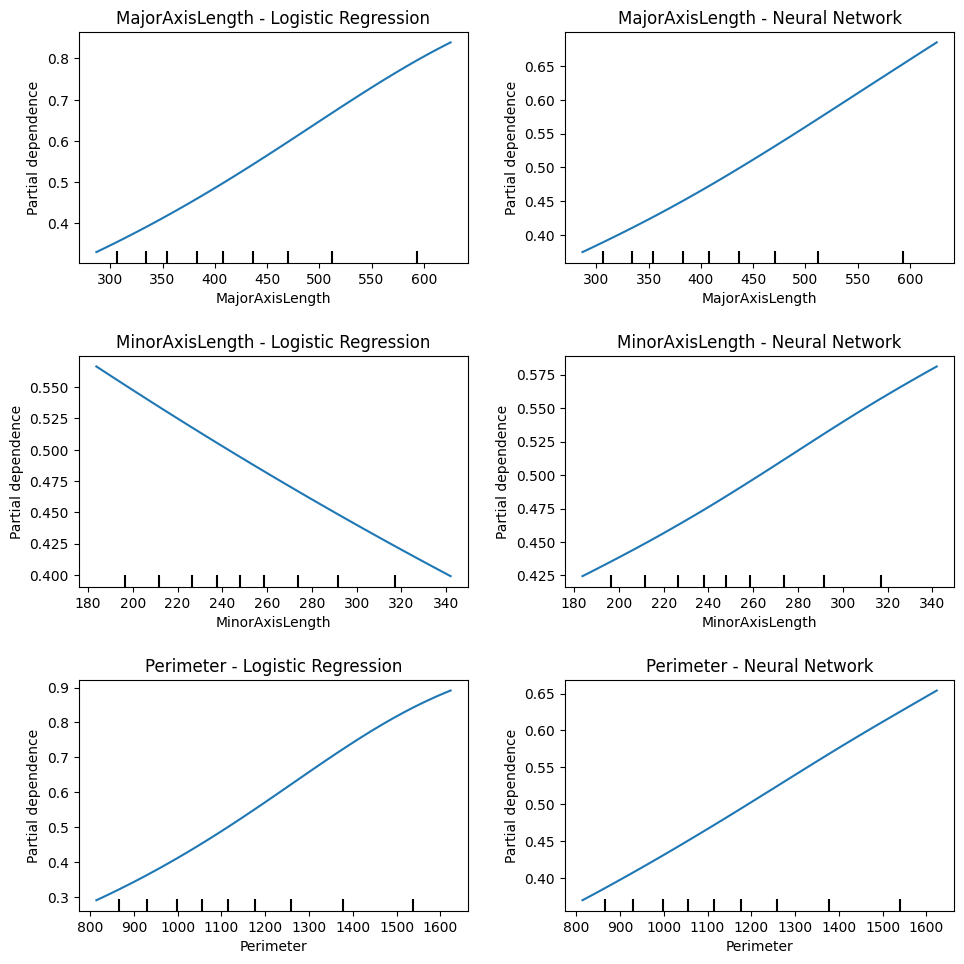

In [22]:
# Define the figure and axes
fig, ax = plt.subplots(3, 2, figsize=(10, 10))  

# Features list
features = ['MajorAxisLength', 'MinorAxisLength', 'Perimeter'] 

# Models list
models = [best_lg, best_nn]
model_names = ['Logistic Regression', 'Neural Network']
ax = ax.flatten()

# Loop through the features 
for i, feature in enumerate(features):
    for j, model in enumerate(models):
        index = 2 * i + j 
        PartialDependenceDisplay.from_estimator(
            estimator=model,
            X=X_train,
            features=[feature],
            ax=ax[index],  
            feature_names=X_train.columns,
            grid_resolution=50)
        ax[index].set_title(f'{feature} - {model_names[j]}')

# Hide any unused axes 
for k in range(index + 1, len(ax)):
    ax[k].set_visible(False)

fig.tight_layout(pad=2.0)
plt.show()

**Key Findings:**
- Both **MajorAxisLength** and **Perimeter** shows a positive relationship, indicating that increases in MajorAxisLength or Perimeter lead to a higher probability of the target being classified as '1'.
- The contrast in how **MinorAxisLength** affects predictions in logistic regression and neural networks is due to their fundamental differences in handling data:
  - Logistic Regression assumes a simple, linear relationship, showing that increasing MinorAxisLength decreases the likelihood of predicting '1'.
  - Neural Network, on the other hand, is a more complex and flexible model that can capture non-linear relationships and interactions between features. The positive slope in the neural network's plot suggests it has learned a different, potentially non-linear relationship where increases in MinorAxisLength lead to an increase in the probability of the target being '1'.

### PDP for Feature Interaction

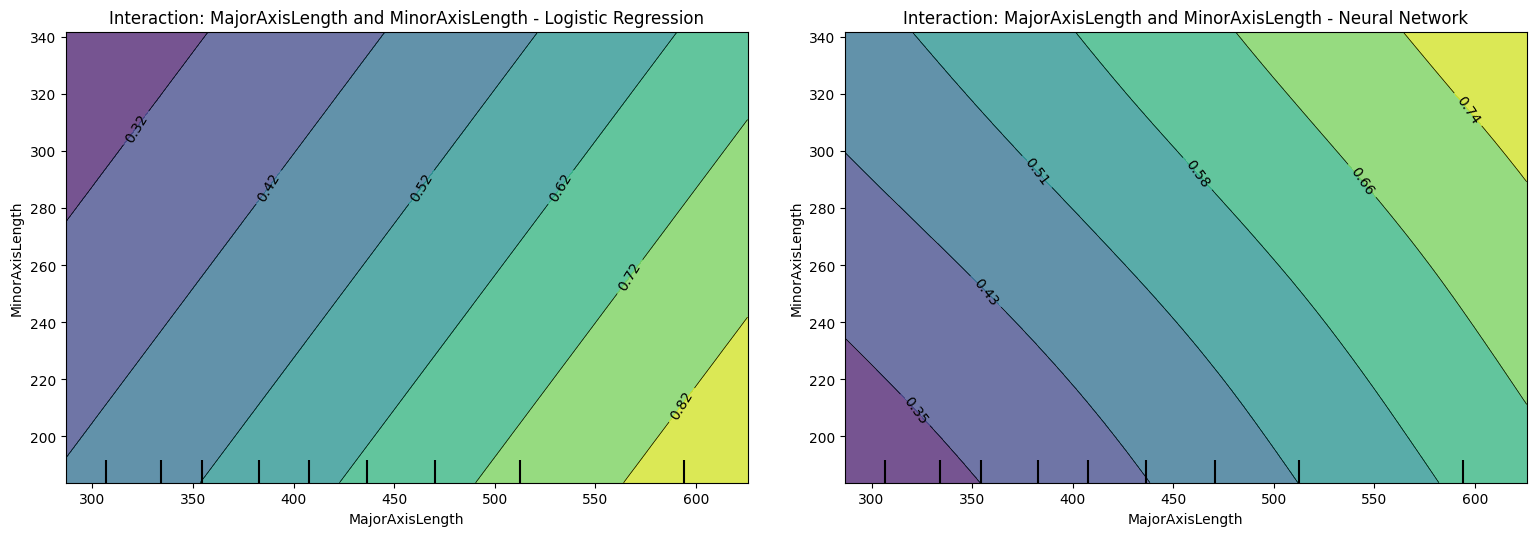

In [23]:
# Define the figure 
fig, ax = plt.subplots(1, 2, figsize=(16, 6))  

# Features tuple for interaction
features = ('MajorAxisLength', 'MinorAxisLength')

# Models for comparison
models = [best_lg, best_nn]
model_names = ['Logistic Regression', 'Neural Network']

# Generate Partial Dependence Plots for each model
for i, model in enumerate(models):
    PartialDependenceDisplay.from_estimator(
        estimator=model,
        X=X_train,
        features=[features],
        ax=ax[i],  # Use the ith subplot
        feature_names=X_train.columns,
        grid_resolution=30 
    )
    ax[i].set_title(f'Interaction: {features[0]} and {features[1]} - {model_names[i]}')

fig.tight_layout(pad=3.0)
plt.show()

**Key Findings:**

- **Logistic Regression:** Shows consistent interaction where as **MajorAxisLength** increases, the predicted probability increases. However, for **MinorAxisLength**, the influence appears somewhat stable across its range, indicating that changes in MinorAxisLength do not significantly alter the probability of the outcome.
- **Neural Network:** Shows a complex interaction where the impact of increasing **MajorAxisLength** has a more pronounced positive effect as **MinorAxisLength** increases, suggesting that larger values of both dimensions simultaneously contribute to a higher likelihood of the target being '1'. This indicates the neural network's capability to capture more nuanced relationships between these features.

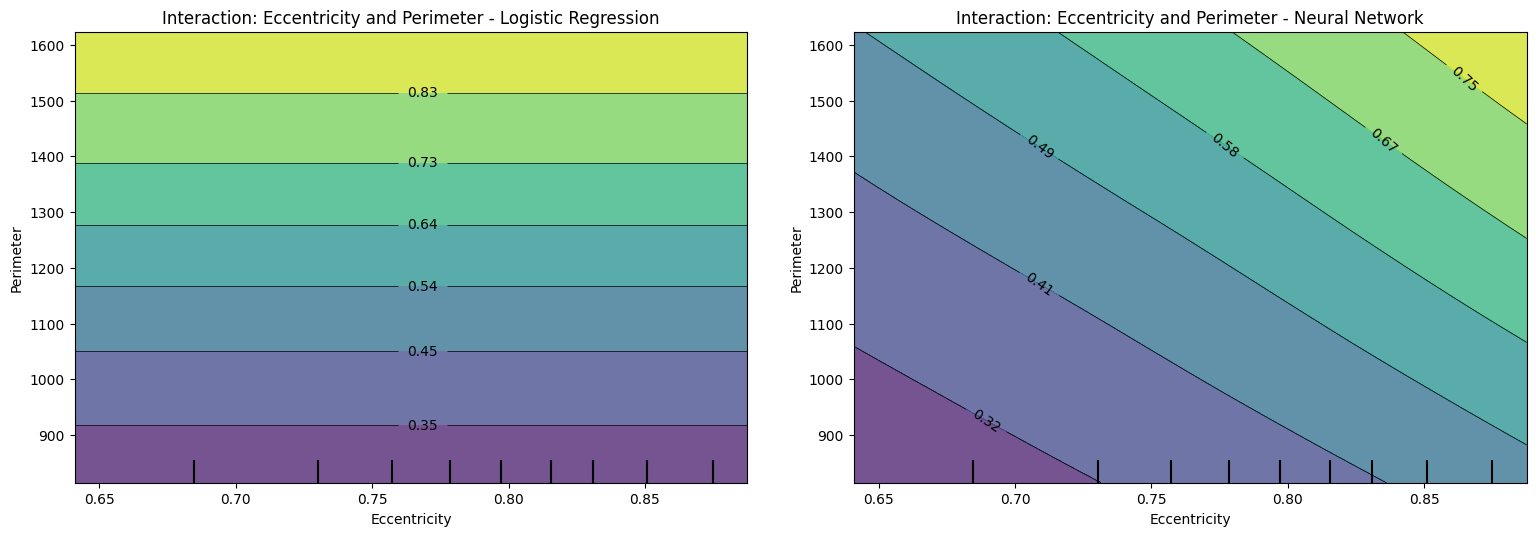

In [24]:
# Define the figure 
fig, ax = plt.subplots(1, 2, figsize=(16, 6))  

# Features tuple for interaction
features = ('Eccentricity', 'Perimeter')

# Models for comparison
models = [best_lg, best_nn]
model_names = ['Logistic Regression', 'Neural Network']

# Generate Partial Dependence Plots for each model
for i, model in enumerate(models):
    PartialDependenceDisplay.from_estimator(
        estimator=model,
        X=X_train,
        features=[features],
        ax=ax[i],  
        feature_names=X_train.columns,
        grid_resolution=30 
    )
    ax[i].set_title(f'Interaction: {features[0]} and {features[1]} - {model_names[i]}')

fig.tight_layout(pad=3.0)
plt.show()

**Key Findings:**

- **Logistic Regression:** **Perimeter** seem is the more significant factor, and within defined perimeter ranges, the model's output probability does not substantially vary with changes in **eccentricity**. 
- **Neural Network:** Unlike the previous logistic regression model, in this neural network model, the **eccentricity** has a clearer influence on the probability. This model suggests a more complex, perhaps nonlinear, interaction pattern, where the combined increase of both features leads to higher probabilities. This is typical of neural networks, which can model more complex relationships than logistic regression.

### ALE Plot 1D

In [25]:
import matplotlib.pyplot as plt
import PyALE

In [26]:
# Define your ModelWrapper here
class ModelWrapper:
    def __init__(self, model, target_index):
        self.model = model
        self.target_index = target_index

    def predict(self, X):
        return self.model.predict_proba(X)[:, self.target_index]
        
# Create plot function
def ale_plot(model, X, feature, target_index, ax, fig):
    wrapped_model = ModelWrapper(model, target_index)
    try:
        ale_result = PyALE.ale(
            X=X, 
            model=wrapped_model, 
            feature=[feature], 
            include_CI=True,  # Assuming confidence intervals are included
            ax=ax,
            fig=fig  # Ensuring the figure is explicitly referenced
        )
        ax.set_title(f'ALE of {feature} - {model.__class__.__name__}')
    except ValueError as e:
        print(f"Error during plotting ALE: {e}")
    return ax

PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


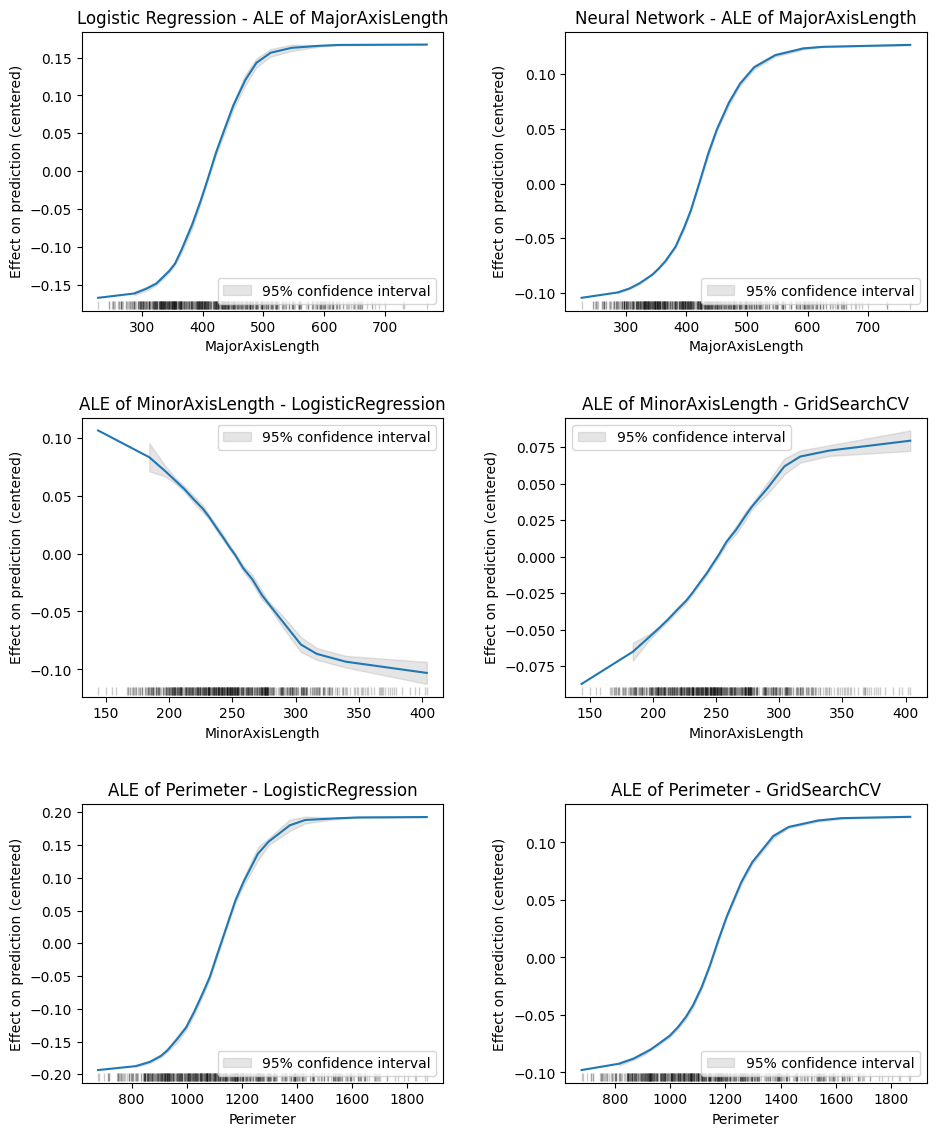

In [27]:
# Define the feature and class index
features = ['MajorAxisLength', 'MinorAxisLength', 'Perimeter']
target_class_index = 1 

# Create a figure 
fig, axs = plt.subplots(3, 2, figsize=(10, 12))  # Adjust the figsize as needed

# Loop through the features and models
models = [best_lg, best_nn]
model_names = ['Logistic Regression', 'Neural Network']

for i, feature in enumerate(features):
    for j, model in enumerate(models):
        ax = axs[i, j]
        ale_plot(model, X_train, feature, target_class_index, ax, fig)
        if i == 0: 
            ax.set_title(f'{model_names[j]} - ALE of {feature}')

plt.tight_layout(pad=3.0)  
plt.show()

**Key Findings:**

- **MajorAxisLength and Perimeter**: Similar with PDP, both models show a positive trend where an increase in MajorAxisLength or Perimeter increases the prediction effect, suggesting that longer MajorAxisLength and Perimeter is associated with a higher likelihood of the target being classified as '1'.
- **MinorAxisLength:**
  - **Logistic Regression:** Displays a nonlinear relationship, with the effect decreasing initially and then slightly increasing as MinorAxisLength increases.
  - **Neural Network:** Shows an almost consistent positive trend, indicating a straightforward relationship where increases in MinorAxisLength uniformly increase the prediction effect.

### Global Surrogate - Logistic Regression

In [28]:
# Make prediction by best model
lg_train_pred_proba = best_lg.predict_proba(X_train)[:, 1]

# Initialize and train Ridge model
ridge = Ridge(random_state=42)
ridge.fit(X_train, lg_train_pred_proba)

# Predict with the Ridge model
ridge_train_pred = ridge.predict(X_train)

# Compute metrics
mae_train = mean_absolute_error(lg_train_pred_proba, ridge_train_pred)
r2_train = r2_score(lg_train_pred_proba, ridge_train_pred)

print(f"MAE on Training Set: {mae_train}")
print(f"R^2 on Training Set: {r2_train}")

MAE on Training Set: 0.12623189058402015
R^2 on Training Set: 0.8625412403786835


In [29]:
# Additional metrics calculation
def compute_metrics(y_true, y_pred_prob):
    # Threshold probabilities at 0.5 for binary classification
    y_pred = (y_pred_prob > 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_prob)
    return {"Accuracy": acc, "AUC": auc}

# Compute additional metrics for Gradient Boosting and Ridge on training data
train_metrics_lg = compute_metrics(y_train, lg_train_pred_proba)
train_metrics_ridge = compute_metrics(y_train, ridge_train_pred)

# Printing results
print("Logistic Regression Training Metrics:")
print(train_metrics_lg)
print("\nRidge Surrogate Training Metrics:")
print(train_metrics_ridge)

Logistic Regression Training Metrics:
{'Accuracy': 0.8870431893687708, 'AUC': 0.9526742838218248}

Ridge Surrogate Training Metrics:
{'Accuracy': 0.8837209302325582, 'AUC': 0.9484572500965943}


In [30]:
# Extracting Ridge Regression Coefficients
ridge_coefs = pd.DataFrame(ridge.coef_, columns=['beta_ridge'], index=X_train.columns)
ridge_intercept = pd.Series(ridge.intercept_, index=["INTERCEPT"], name="beta_ridge")

# Combine coefficients and intercept into a single DataFrame
df_coef = pd.concat([ridge_coefs, ridge_intercept.to_frame()])
print(df_coef)

                 beta_ridge
Area              -0.000036
MajorAxisLength    0.001504
MinorAxisLength    0.002002
Eccentricity       0.393473
ConvexArea         0.000023
Extent            -0.098465
Perimeter          0.002229
INTERCEPT         -2.389082


In [31]:
# Extracting Logistic Regression Coefficients
lg_coef

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,INTERCEPT
Model Coefficients,-0.000992,0.013039,-0.013841,0.000035,0.001005,-0.000022,0.006403,-12.990122


**Key Findings:**

- The coefficients obtained from the Logistic regression model differ from those of the Ridge Regression.
- The direction of influence for most features remains consistent between the two models, the magnitude of the coefficients varies, indicating the effect of regularization in Ridge Regression on coefficient shrinkage and stability.

### Global Surrogate - Neural Network

In [32]:
# Make prediction by best model
nn_train_pred_proba = best_nn.predict_proba(X_train)[:, 1]

# Initialize and train Ridge model
ridge = Ridge(random_state=42)
ridge.fit(X_train, nn_train_pred_proba)

# Predict with the Ridge model
ridge_train_pred = ridge.predict(X_train)

# Compute metrics
mae_train = mean_absolute_error(nn_train_pred_proba, ridge_train_pred)
r2_train = r2_score(nn_train_pred_proba, ridge_train_pred)

print(f"MAE on Training Set: {mae_train}")
print(f"R^2 on Training Set: {r2_train}")

MAE on Training Set: 0.09552921838325848
R^2 on Training Set: 0.9043084219171387


In [33]:
# Compute additional metrics for Neural Network and Ridge on training data
train_metrics_nn = compute_metrics(y_train, nn_train_pred_proba)
train_metrics_ridge = compute_metrics(y_train, ridge_train_pred)

# Printing results
print("Neural Network Training Metrics:")
print(train_metrics_nn)
print("\nRidge Surrogate Training Metrics:")
print(train_metrics_ridge)

Neural Network Training Metrics:
{'Accuracy': 0.8787375415282392, 'AUC': 0.9407738588066458}

Ridge Surrogate Training Metrics:
{'Accuracy': 0.8787375415282392, 'AUC': 0.9422752111276702}


In [34]:
# Extracting Ridge Regression Coefficients
ridge_coefs = pd.DataFrame(ridge.coef_, columns=['beta_ridge'], index=X_train.columns)
ridge_intercept = pd.Series(ridge.intercept_, index=["INTERCEPT"], name="beta_ridge")

# Combine coefficients and intercept into a single DataFrame
df_coef = pd.concat([ridge_coefs, ridge_intercept.to_frame()])
print(df_coef)

                   beta_ridge
Area            -1.048395e-05
MajorAxisLength  3.150310e-03
MinorAxisLength  3.093360e-03
Eccentricity     4.053670e-01
ConvexArea       8.858162e-07
Extent          -4.238268e-01
Perimeter        8.702607e-04
INTERCEPT       -1.841091e+00


**Compare with logistic regression:**

- Consistency in Influence: Both models consistently highlight the importance of features like Eccentricity, MajorAxisLength, and MinorAxisLength, with similar positive coefficients.

- Differences in Weights: There are notable differences in the weights assigned to features between the two models. For instance, the Neural Network assigns a higher weight to features like MajorAxisLength and MinorAxisLength compared to Logistic Regression.

## 4.3. Local Model-Agnostic Methods

### Individual Conditional Expectation (ICE)

In [35]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

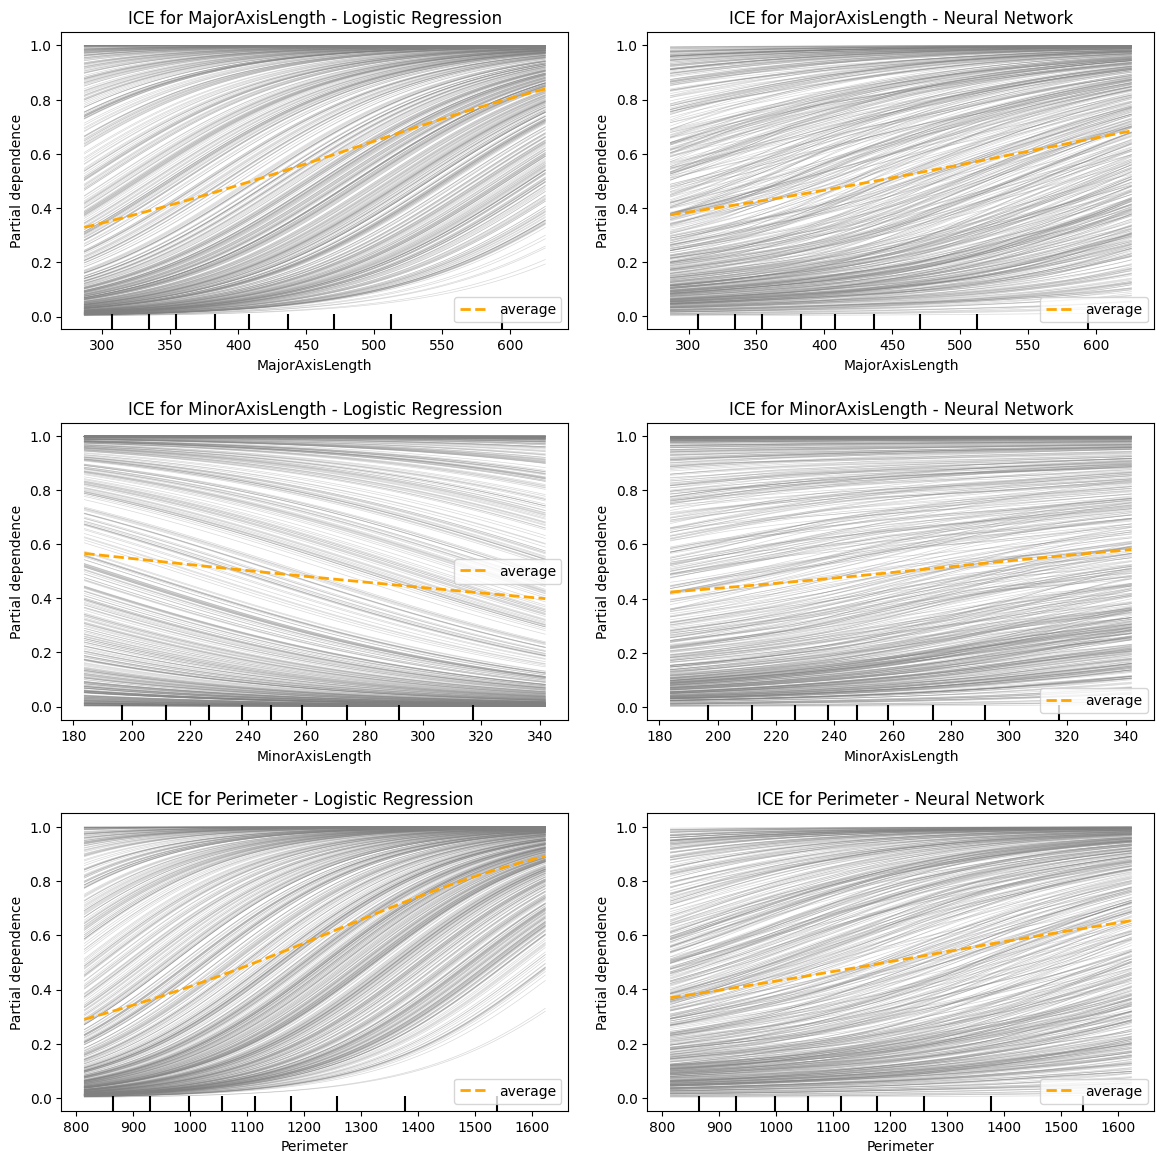

In [36]:
# Feature list
features = ['MajorAxisLength', 'MinorAxisLength', 'Perimeter']

# Setup the figure and axes
fig, axs = plt.subplots(3, 2, figsize=(12, 12))  
axs = axs.flatten()  

# Models list
models = [best_lg, best_nn]
model_names = ['Logistic Regression', 'Neural Network']

# Loop through the list of features 
for i, feature in enumerate(features):
    for j, model in enumerate(models):
        ax_index = 2 * i + j  
        PartialDependenceDisplay.from_estimator(
            estimator=model,
            X=X_train,
            features=[feature],
            target=1,  
            kind="both",
            ice_lines_kw={"color": "#808080", "alpha": 0.3, "linewidth": 0.5},
            pd_line_kw={"color": "#ffa500", "linewidth": 2, "alpha": 1},
            ax=axs[ax_index]
        )
        axs[ax_index].set_title(f'ICE for {feature} - {model_names[j]}')

fig.tight_layout(pad=2.0)
plt.show()

**Key Findings:**

- **MajorAxisLength:** Both Logistic Regression and Neural Network models show a consistent positive trend for MajorAxisLength. As MajorAxisLength increases, the partial dependence on the prediction also increases linearly.
- **MinorAxisLength:** Similar with PDP, two models capture completely opposite effects of MinorAxisLength on the prediction outcome. Logistic regression shows a negative relationship, while the neural network shows a positive relationship. This divergence highlights the fundamental differences in how these models handle data relationships and their underlying assumptions or capacity to model complexity.
- **Perimeter:** Both models display similar trends for Perimeter, with a positive relationship between the increase in Perimeter and the effect on the predictions.

### SHAP

In [37]:
import shap

/home/hanhtran/miniconda3/envs/tf2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
# Initialize the SHAP Explainer
# Logistic Regression 
explainer_lg = shap.Explainer(best_lg.predict_proba, X_test)
shap_values_lg = explainer_lg(X_test)

# Neural Network 
explainer_nn = shap.Explainer(best_nn.predict_proba, X_test)
shap_values_nn = explainer_nn(X_test)

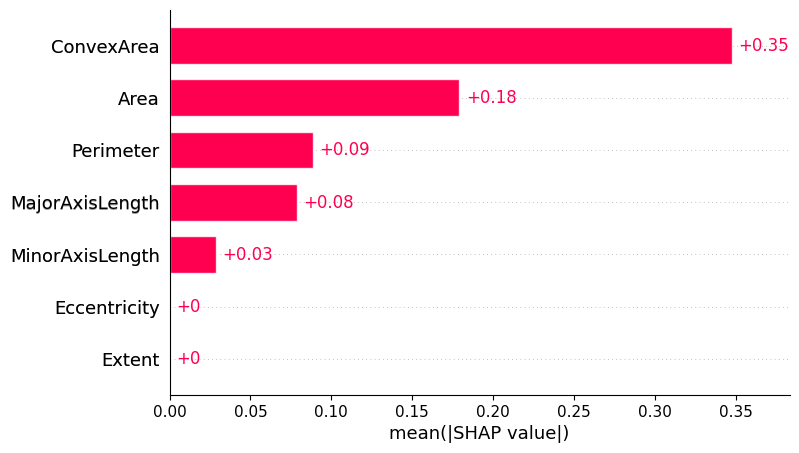

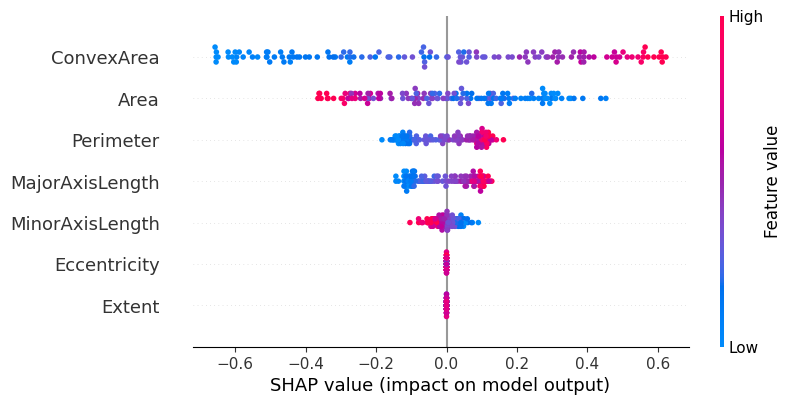

In [39]:
# Plotting SHAP plot for Logistic Regression
shap.plots.bar(shap_values_lg[:,:,1])
shap.plots.beeswarm(shap_values_lg[:,:,1]) 

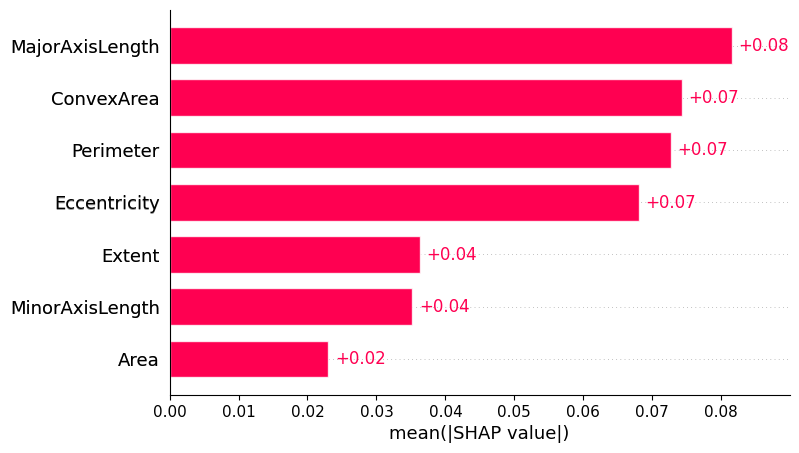

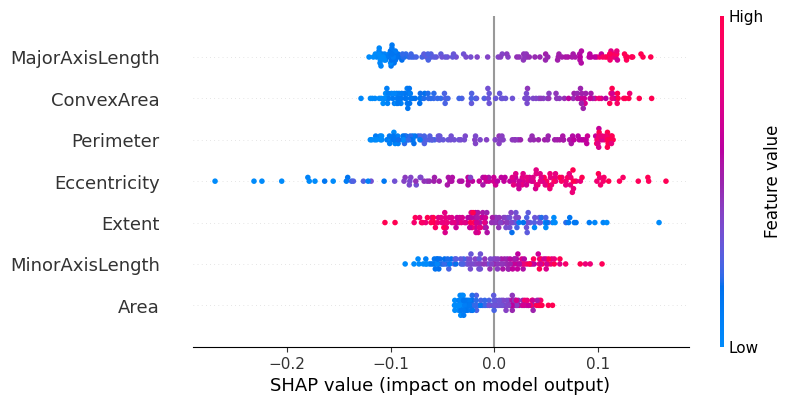

In [40]:
# Plotting SHAP plot for Neural Network
shap.plots.bar(shap_values_nn[:,:,1])
shap.plots.beeswarm(shap_values_nn[:,:,1])

**Key Findings:**

- **MajorAxisLength** is significant in both models, but its impact is more pronounced in the Neural Network.
- **ConvexArea** and **Perimeter** also have important roles in both models, though the relative importance of **ConvexArea** is slightly more in the Logistic Regression.
- The overall spread of **SHAP** values across features in the Neural Network suggests a more balanced contribution of features compared to the Logistic Regression, where a few features dominated. The Neural Network may be more sensitive to subtle variations in features, as indicated by the broader spread of SHAP values across many features, compared to the more focused influence in Logistic Regression.

# 5. Summary

## 5.1 Overall Conclusion

**Logistic Regression:**
- **Simple Relationships:** Exhibits linear relationships where increases in MajorAxisLength and Perimeter lead to higher classification probabilities. MinorAxisLength negatively affects the outcome, indicating a decrease in the likelihood of '1' classification.
- **Limited Interactions:** Shows stable and predictable interactions, with limited complexity observed in how changes in features influence predictions.
- **Focused Influencers:** Key influences come from MajorAxisLength, ConvexArea, and Perimeter. The influence patterns are straightforward, reflected by consistent trends across interpretation methods like ALE, ICE, and SHAP.

**Neural Network:**
- **Complex Dynamics:** Captures complex, possibly non-linear relationships, notably with MinorAxisLength, which positively impacts classification contrary to logistic regression.
- **Sensitive to Interactions:** Demonstrates heightened sensitivity to changes in features, with enhanced interaction effects particularly between MajorAxisLength vs MinorAxisLength and Eccentricity vs Perimeter.
- **Balanced Feature Contribution:** SHAP values indicate a more distributed influence across features, suggesting an ability to detect and utilize subtle feature variations.

## 5.2 Pros and Cons of each technique

**PDP and ICE:**
- **Advantages**: Illustrate the effect of a single feature or feature interactions across the entire data range, providing clear, understandable visualizations. ICE adds the benefit of showing these effects for individual observations, revealing variability and interactions that PDP averages out.
- **Disadvantages**: The assumption of independence is the biggest issue. It can be misleading if strong feature interactions exist, as they average out such effects. ICE can become cluttered and harder to interpret with large datasets.

**ALE:**
- **Advantages**: ALE provides greater accuracy than PDP when dealing with correlated features by accumulating local effects. This method is faster and provides clear interpretations without the bias often found in PDPs.
- **Disadvantages**: Can be complex to compute and interpret, particularly with many categorical variables or intricate interactions. Its effects may deviate from the expected linear regression coefficients due to interactions and correlations among features. ALE does not include ICE curves for individual effect visualization, and stability of second-order estimates varies across the feature space without clear visualization.

**Ridge Surrogate:**
- **Advantages**: Simplicity and Clarity: This method offers a straightforward linear explanation of a model's behavior through its coefficients, paired with the flexibility of the surrogate model approach. The use of R-squared allows for an easy assessment of how accurately the surrogate approximates the original model’s predictions.
- **Disadvantages**: Oversimplification: This method may overly simplify complex models like neural networks, potentially omitting critical interpretive details. It's important to remember that conclusions are drawn about the model's behavior, not directly about the underlying data. Additionally, there's ambiguity about what constitutes a satisfactory R-squared value, and some argue that no model is inherently interpretable, cautioning against the false security of perceived interpretability.
  
**SHAP:**
- **Advantages**:  Provide detailed insights into each feature's contribution to predictions, supporting both local and global interpretability. It's based on solid game theory principles, ensuring a fair distribution of the prediction impact among features. SHAP integrates concepts from LIME and Shapley values and offers a fast implementation for tree-based models.
- **Disadvantages**:  Require significant computational resources, which can complicate its use in large, complex models. KernelSHAP, in particular, is slow and overlooks feature dependencies. TreeSHAP may produce counterintuitive attributions. Additionally, SHAP interpretations can be intentionally manipulated, potentially leading to misleading conclusions.